Este notebook contiene el entrenamiento de los modelos de redes neuronales empleando los datos de la ETSISI, las arquitecturas definidas son las correspondientes a las últimas pruebas que se han realizado.

In [2]:
import pandas as pd
import numpy as np
import os
import random
import warnings

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, LeakyReLU
from keras.initializers import he_normal
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.utils import plot_model
from keras import regularizers, layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
warnings.filterwarnings("ignore")

In [4]:
def cargar_datos_velodyne(archivo):
    nombres_columnas = ['X', 'Y', 'Z', 'Intensidad']
    datos = pd.read_csv(archivo, sep=' ', header=None, names=nombres_columnas)
    
    return datos

In [ ]:
# Imagenes completas
original = "ruta a las imagenes originales"
reduced = "ruta a las imagen reducidas"

In [6]:
# Imágenes recortadas
# original = 'ruta a las imagenes originales recortadas'
# reduced = 'ruta a las imagen reducidas recortadas'

In [7]:
def load_paired_images(original_dir, downsampled_dir):
    """

    Carga los pares de imagenes originales y downsampled de un directorio especifico.
    Se asume que las imagenes estan nombradas con el mismo nombre en ambos directorios.
    
    Args:
    - original_dir (str): Directorio que contiene las imagenes originales.
    - downsampled_dir (str): Directorio que contiene las imagenes downsampled.
    
    Returns:
    - lista de tuplas: Cada tupla contiene un par de imagenes (original, downsampled) como numpy arrays.
    """
    image_pairs = []
    
    # Coge todos los nombres de los archivos del directorio y los ordena. Las instancias de su versión auxiliar tienen el mismo nombre, por lo que solo es necesario
    # referenciar a uno de los directorios.
    downsampled_images = sorted([f for f in os.listdir(downsampled_dir) if f.endswith('.png')])
    

    for downsampled_image_filename in downsampled_images:   # Itera sobre cada archivo en el directorio de imagenes
        downsampled_image_path = os.path.join(downsampled_dir, downsampled_image_filename)   # Genera la ruta del archivo para la imagen
        
        # Genera la ruta del archivo para las imagenes de la carpeta auxiliar
        original_image_filename = downsampled_image_filename
        original_image_path = os.path.join(original_dir, original_image_filename)
        
        # Carga las imagenes originales y downsampled
        downsampled_image = Image.open(downsampled_image_path).convert('L')
        original_image = Image.open(original_image_path).convert('L')
        
        # Añade las imagenes a la lista de pares
        image_pairs.append((np.array(original_image, dtype=np.float32) / 255.0, 
                            np.array(downsampled_image, dtype=np.float32) / 255.0))
    
    return image_pairs

In [8]:
def load_lidar_images(original_dir, downsampled_dir, start_idx=1000, end_idx=3000):
    """
    Carga las imagenes de la nube de puntos LiDAR de los directorios especificados para las imagenes originales y downsampled.
    La funcion asume que las imagenes estan nombradas con el mismo nombre en ambos directorios.
    
    Por condiciones de memoria, se puede especificar un rango de indices para cargar solo un subconjunto de imagenes.
    
    Args:
    - original_dir (str): Directorio que contiene las imagenes originales.
    - downsampled_dir (str): Directorio que contiene las imagenes reducidas.
    - start_idx (int): Indice de inicio para la extracción de imágenes.
    - end_idx (int): Indice de fin para la extracción de imágenes.
    
    Returns:
    - original images: Las imagenes originales de la nube de puntos
    - downsampled images: Las imagenes reducidas de la nube de puntos
    """
    original_list = []
    downsampled_list = []
    
    # Coge todos los nombres de los archivos del directorio y los ordena
    downsampled_images = sorted([f for f in os.listdir(downsampled_dir) if f.endswith('.png')])
    
    # Selecciona un subconjunto de imagenes para cargar
    subset_downsampled_images = downsampled_images[start_idx:end_idx]
    

    for downsampled_image_filename in subset_downsampled_images:

        downsampled_image_path = os.path.join(downsampled_dir, downsampled_image_filename)   # Se genera la ruta del archivo para la imagen
        
        # Se genera la ruta del archivo para las imagenes de la carpeta auxiliar
        original_image_filename = downsampled_image_filename
        original_image_path = os.path.join(original_dir, original_image_filename)
        
        # Se cargan las imagenes originales y downsampled
        downsampled_image = Image.open(downsampled_image_path).convert('RGB')
        original_image = Image.open(original_image_path).convert('RGB')
        

        original_list.append(np.array(original_image, dtype=np.float32) / 255.0)
        downsampled_list.append(np.array(downsampled_image, dtype=np.float32) / 255.0)

    # Se convierten las listas a arrays
    original_array = np.stack(original_list, axis=0)
    downsampled_array = np.stack(downsampled_list, axis=0)
    
    return original_array, downsampled_array

In [9]:
def load_random_images(original_dir, downsampled_dir, num_samples=2000):
    """
    Carga las imagenes de la nube de puntos LiDAR de los directorios especificados para las imagenes originales y downsampled.
    La funcion asume que las imagenes estan nombradas con el mismo nombre en ambos directorios.

    Selecciona un subconjunto aleatorio de imagenes para cargar.
    
    Args:
    - original_dir (str): Directorio que contiene las imagenes originales.
    - downsampled_dir (str): Directorio que contiene las imagenes reducidas.
    - num_samples (int): Numero de imagenes a tomar aleatoriamente.
    
    Returns:
    - original images: Las imagenes originales de la nube de puntos
    - downsampled images: Las imagenes reducidas de la nube de puntos
    """
    original_list = []
    downsampled_list = []
    
    # Carrega todos los nombres de los archivos del directorio y los ordena
    downsampled_images = sorted([f for f in os.listdir(downsampled_dir) if f.endswith('.png')])
    
    # Seleciona un subconjunto aleatorio de imagenes para cargar
    if num_samples > len(downsampled_images):
        raise ValueError("Number of samples requested exceeds the number of available images")
        
    random_sampled_images = random.sample(downsampled_images, num_samples)
    
    
    for downsampled_image_filename in random_sampled_images:

        downsampled_image_path = os.path.join(downsampled_dir, downsampled_image_filename) # Construye la ruta del archivo para la imagen
        
        # Construye la ruta del archivo para las imagenes de la carpeta auxiliar
        original_image_filename = downsampled_image_filename
        original_image_path = os.path.join(original_dir, original_image_filename)
        
        # Carga las imagenes originales y downsampled   
        downsampled_image = Image.open(downsampled_image_path).convert('RGB')
        original_image = Image.open(original_image_path).convert('RGB')
        
        original_list.append(np.array(original_image, dtype=np.float32) / 255.0)
        downsampled_list.append(np.array(downsampled_image, dtype=np.float32) / 255.0)

    # Convierte las listas a arrays numpy
    original_array = np.stack(original_list, axis=0)
    downsampled_array = np.stack(downsampled_list, axis=0)
    
    return original_array, downsampled_array

In [10]:
original_processed, downsample_processed = load_random_images(original, reduced, num_samples=2000)

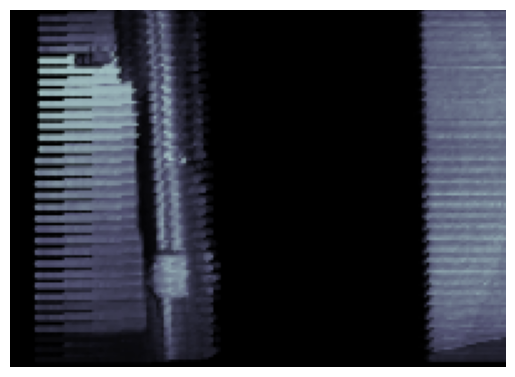

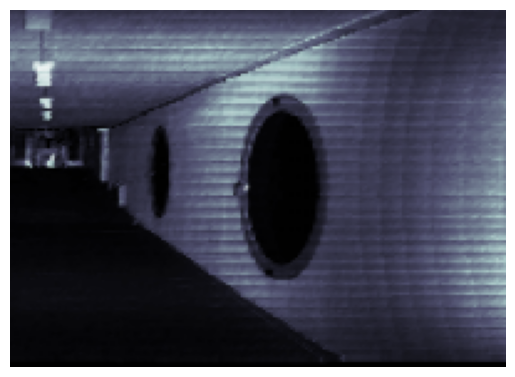

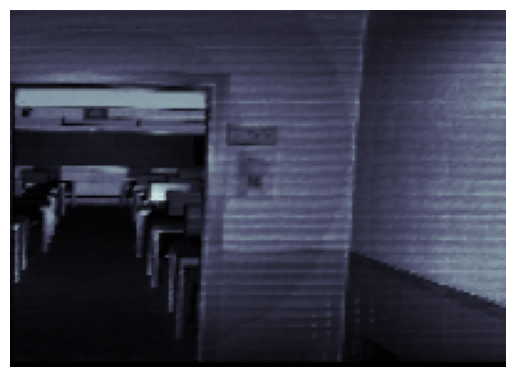

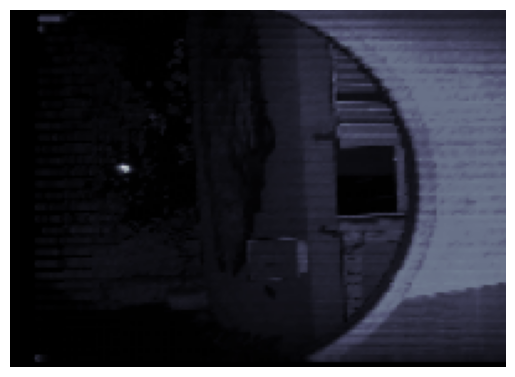

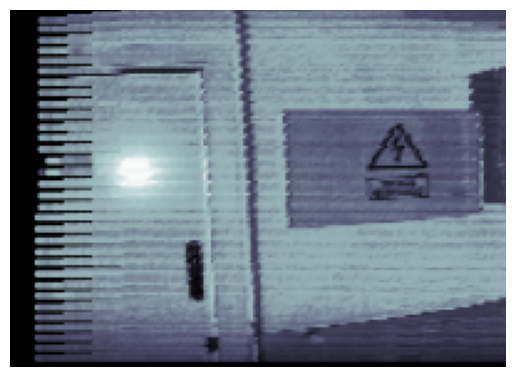

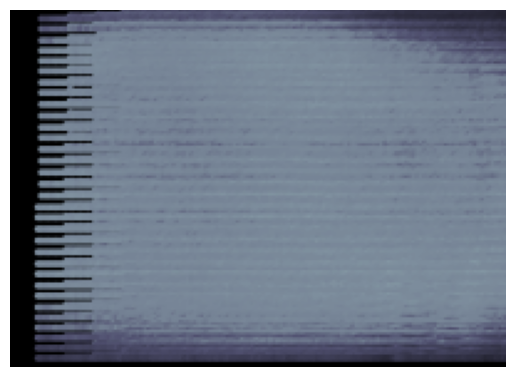

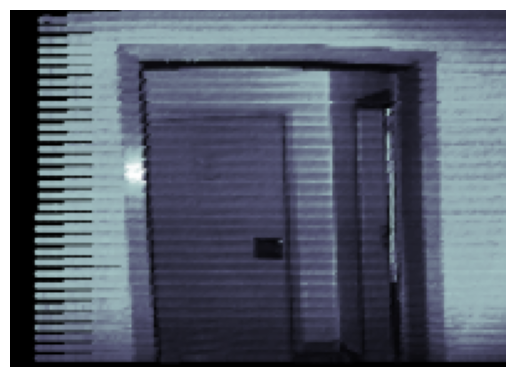

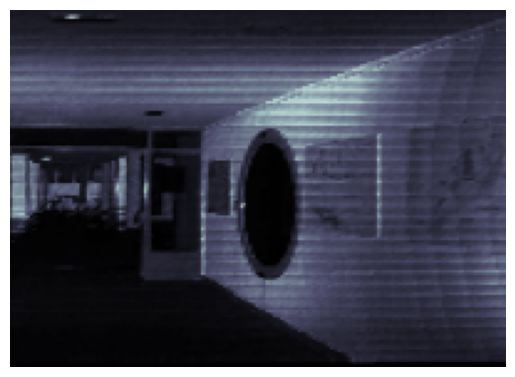

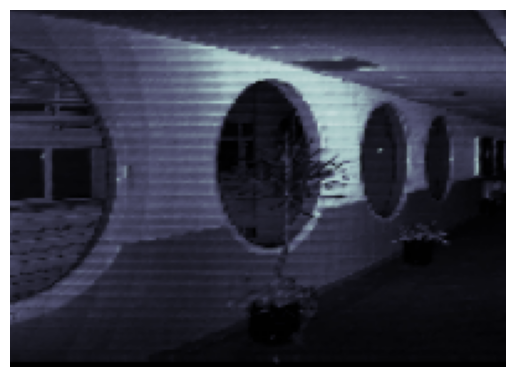

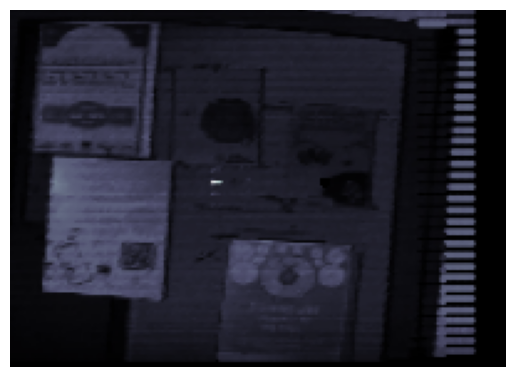

In [12]:
indices = np.random.choice(len(original_processed), 10, replace=False)

for i in indices:
    plt.imshow(original_processed[i])
    plt.axis('off')
    plt.show()

In [13]:
def visualize_image(original_image, downsampled_image):
    """
    Visualiza un par de imagenes de una lista de pares de imagenes.
    
    Args:
    - Tupla de imágenes (list of tuples): Cada tupla contiene un par de imágenes (original, downsampled) como numpy arrays.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(downsampled_image)
    ax2.set_title('Downsampled Image')
    ax2.axis('off')
    
    plt.show()

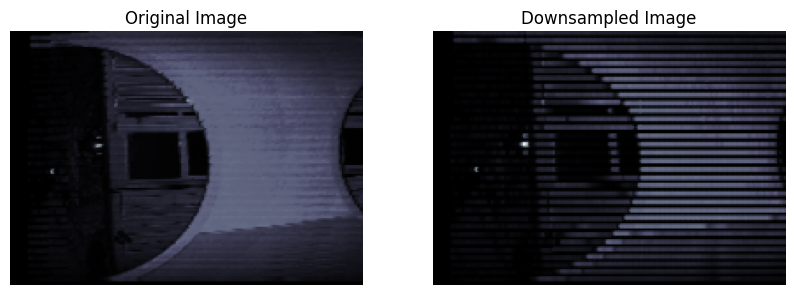

In [14]:
visualize_image(original_processed[0], downsample_processed[0])

## Interpolación de los puntos mediante Interpolación

Para establecer una base de la que partir realizamos interpolación sobre imagen, un proceso donde empleando datos conocidos se estiman los valores en coordenadas desconocidas. El objetivo es obtener la mejor aproximación en la intensidad de los pixeles en base a sus vecinos en la imagen.

La segunda aproximación, interpolación aplicada sobre la nube de puntos tridimensional, será realizada en el notebook "interpolation.ipynb"

##### Imagen Original

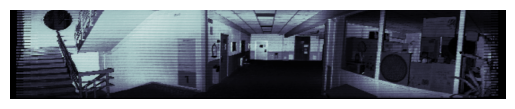

In [20]:
plt.imshow(original_processed[0], cmap='gray')
plt.axis('off')
plt.show()

#### Interpolación mediante el vecino mas cercano

Uno de los modelos de interpolación más simple, se basa en la replicación de los pixeles vecinos, replicando la intensidad del color sobre los nuevos pixeles. El problema que conlleva el uso de este tipo de algoritmos es la aparición de bloques de pixeles en la imagen, ya que debido a su naturaleza, se generan regiones de pixeles con la misma intensidad.

In [21]:
image = downsample_processed[0]

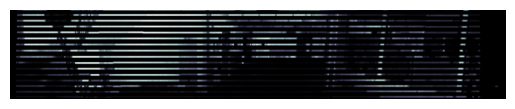

In [34]:
import cv2
new_image = cv2.resize(image, (3200, 576), interpolation=cv2.INTER_NEAREST)

plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.show()

#### Bilinear Interpolation

La interpolación bilinear deriva de la interpolación lineal simple, toma la intensidad media de los 4 vecinos más cercanos para promediar los nuevos pixeles a la hora de escalar la imagen, obteniendo una representación más precisa del entorno teniendo en consideración una ventana de 2x2 del pixel objetivo.

El problema derivado en el uso de este tipo de algoritmos es la aparición de defuminado cuando la imagen es reescalada a un tamaño considerable. La mejora de resolución no ayuda a la obtención de nuevas capas sino a la mejora de las capas existentes

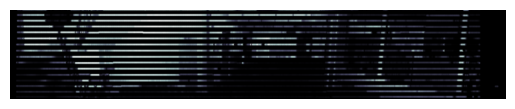

In [35]:
scaled_image_linear = cv2.resize(image, (3200, 576), interpolation=cv2.INTER_LINEAR)

plt.imshow(scaled_image_linear, cmap='gray')
plt.axis('off')
plt.show()

### Bicubic Interpolation

Es una extensión de la interpolación cúbica que se aplica sobre ventanas de píxeles vecinos, específicamente trabaja con una ventana de 4 $\times$ 4 píxeles.

Similar a la interpolación bilineal, la interpolación bicúbica no propicia la generación de bloques de píxeles que empleando el método del vecino más cercano, pero sí genera un difuminado de la imagen al tratar de cambiar su tamaño.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


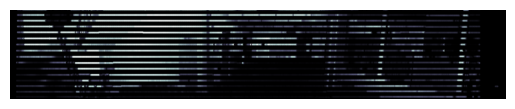

In [36]:
import cv2
new_image = cv2.resize(image, (3200, 576), interpolation=cv2.INTER_CUBIC)

plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.show()

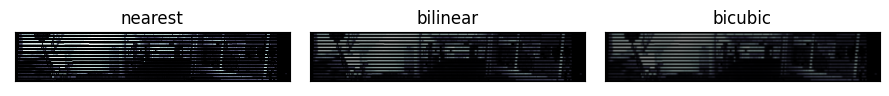

In [25]:
methods = ['nearest', 'bilinear', 'bicubic']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, interp_method in zip(axs.flat, methods):
    ax.imshow(image, interpolation=interp_method, cmap='viridis')
    ax.set_title(str(interp_method))

plt.tight_layout()
plt.show()

***

## Autoencoder

#### Imágenes completas

In [11]:
# Mantenemos las imágenes restantes como conjunto de test
orig_test = original_processed[1500:]
down_test = downsample_processed[1500:]

# Separamos las primeras 3500 imágenes para entrenamiento
original_processed = original_processed[:1500]
downsample_processed = downsample_processed[:1500]

#### Imágenes recortadas

In [12]:
# # Separamos las primeras 3500 imágenes para entrenamiento
# original_processed = original_processed[:3500]
# downsample_processed = downsample_processed[:3500]

# # Mantenemos las imágenes restantes como conjunto de test
# orig_test = original_processed[3500:]
# down_test = downsample_processed[3500:]

***

In [13]:
train_orig, test_orig, train_down, test_down = train_test_split(original_processed, downsample_processed, test_size=0.2, random_state=42)

In [15]:
print(train_orig.shape)
print(test_orig.shape)
print(train_down.shape)
print(test_down.shape)

(1200, 144, 200, 3)
(300, 144, 200, 3)
(1200, 144, 200, 3)
(300, 144, 200, 3)


In [16]:
# Reshape the data to include a channel dimension
train_orig = np.expand_dims(train_orig, axis=-1)
train_down = np.expand_dims(train_down, axis=-1)
test_orig = np.expand_dims(test_orig, axis=-1)
test_down = np.expand_dims(test_down, axis=-1)
orig_test = np.expand_dims(orig_test, axis=-1)
down_test = np.expand_dims(down_test, axis=-1)  

print("New Train Original Shape:", train_orig.shape)
print("New Train Downsampled Shape:", train_down.shape)
print("New Test Original Shape:", test_orig.shape)
print("New Test Downsampled Shape:", test_down.shape)
print("New Original Test Shape:", orig_test.shape)
print("New Downsampled Test Shape:", down_test.shape)

New Train Original Shape: (1200, 144, 200, 3, 1)
New Train Downsampled Shape: (1200, 144, 200, 3, 1)
New Test Original Shape: (300, 144, 200, 3, 1)
New Test Downsampled Shape: (300, 144, 200, 3, 1)
New Original Test Shape: (500, 144, 200, 3, 1)
New Downsampled Test Shape: (500, 144, 200, 3, 1)


In [17]:
train_orig.shape

(1200, 144, 200, 3, 1)

In [18]:
# non_zero_data = train_orig[train_orig != 0].flatten()

# counts, bin_edges = np.histogram(non_zero_data, bins=50)

# print("Counts:", counts)
# print("Bin edges:", bin_edges)

# plt.figure(figsize=(10, 6))
# plt.hist(non_zero_data, bins=50, color='blue', alpha=0.7)
# plt.title("Distribution of Non-Zero Values")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()

In [19]:
non_zero_mask = train_orig != 0

mean_value = np.median(train_orig[non_zero_mask])

print("Mean value excluding zeros:", mean_value)

Mean value excluding zeros: 0.18431373


In [20]:
# scaler = StandardScaler()


# train_orig_scaled = scaler.fit_transform(train_orig.reshape(-1, 1)).reshape(train_orig.shape)
# train_down_scaled = scaler.transform(train_down.reshape(-1, 1)).reshape(train_down.shape)
# test_orig_scaled = scaler.transform(test_orig.reshape(-1, 1)).reshape(test_orig.shape)
# test_down_scaled = scaler.transform(test_down.reshape(-1, 1)).reshape(test_down.shape)

In [21]:
# scaler = MinMaxScaler()


# train_orig_scaled = scaler.fit_transform(train_orig.reshape(-1, 1)).reshape(train_orig.shape)
# train_down_scaled = scaler.transform(train_down.reshape(-1, 1)).reshape(train_down.shape)
# test_orig_scaled = scaler.transform(test_orig.reshape(-1, 1)).reshape(test_orig.shape)
# test_down_scaled = scaler.transform(test_down.reshape(-1, 1)).reshape(test_down.shape)

In [22]:
# non_zero_data = train_orig[train_orig_scaled != 0].flatten()

# counts, bin_edges = np.histogram(non_zero_data, bins=50)  # Adjust bins as needed

# print("Counts:", counts)
# print("Bin edges:", bin_edges)


# plt.figure(figsize=(10, 6))
# plt.hist(non_zero_data, bins=50, color='blue', alpha=0.7)  # Histogram plotting
# plt.title("Distribution of Non-Zero Values")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()

In [23]:
# visualize_image(train_orig_scaled[0], train_down_scaled[0])

In [23]:
def plot_loss(h, EPOCHS):
    LOSS = 0
    training = np.zeros(EPOCHS)
    testing = np.zeros(EPOCHS)
    training = h.history['loss']
    testing = h.history['val_loss']

    epochs = range(1, EPOCHS + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training, 'b-', label='Training loss')
    plt.plot(epochs, testing, 'y-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [24]:
input_dim = (144, 200, 3)
input_layer = Input(shape=input_dim)
EPOCHS = 20

#### Modelo 1 (outdated)

In [ ]:
# Encoder
encoder = Conv2D(32, (11, 11), activation='relu', padding='same')(input_layer)
encoder = Conv2D(64, (11, 11), activation='relu', padding='same')(encoder)
encoder = Dropout(0.3)(encoder)
# encoder = BatchNormalization()(encoder)
# encoder = Dropout(0.3)(encoder)
# encoder = BatchNormalization()(encoder)
# encoder = Dropout(0.3)(encoder)
# encoder = Conv2D(256, (7, 7), activation='relu', padding='same')(encoder)
# encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)

encoder = Conv2D(128, (7, 7), activation='relu', padding='same')(encoder)
# encoder = Dense(128, activation='relu')(encoder)
# Decoder
# decoder = Conv2DTranspose(32, (12, 12), activation='relu', padding='same')(encoder)
# decoder = Conv2DTranspose(512, (3, 3), activation='relu', padding='same')(encoder)
# decoder = Conv2DTranspose(256, (7, 7), activation='relu', padding='same')(encoder)
# decoder = Conv2DTranspose(128, (7, 7), activation='relu', padding='same')(encoder)
# decoder = Dropout(0.3)(decoder)
decoder = Conv2DTranspose(64, (11, 11), activation='relu', padding='same')(encoder)
decoder = Dropout(0.3)(decoder)
decoder = Conv2DTranspose(32, (11, 11), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (7, 7), activation='sigmoid', padding='same')(decoder)

#### Modelo auxiliar (Prueba en imágenes recortadas)

In [36]:
encoder = Conv2D(32, (11, 11), activation='relu', padding='same')(input_layer)
encoder = Conv2D(64, (11, 11), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)

encoder = Conv2D(128, (7, 7), activation='relu', padding='same')(encoder)
encoder = Conv2D(128, (7, 7), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.3)(encoder)

# encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
# encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D((2, 2), padding='same')(encoder)
# encoder = Dropout(0.3)(encoder)

# decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
# decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)
# decoder = Dropout(0.3)(decoder)

decoder = Conv2DTranspose(128, (7, 7), strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2D(128, (7, 7), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)
decoder = Dropout(0.3)(decoder)

decoder = Conv2DTranspose(64, (11, 11), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2D(32, (11, 11), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(3, (7, 7), activation='sigmoid', padding='same')(decoder)

In [37]:
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [38]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 200, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 144, 200, 32)      11648     
                                                                 
 conv2d_26 (Conv2D)          (None, 144, 200, 64)      247872    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 72, 100, 64)      0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 72, 100, 128)      401536    
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 100, 128)      802944    
                                                           

In [39]:
history = autoencoder.fit(train_down, train_orig, epochs=10, batch_size=4, validation_data=(test_down, test_orig))

Epoch 1/10
300/300 [==============================] - 1030s 3s/step - loss: 0.0267 - val_loss: 0.0131
Epoch 2/10
300/300 [==============================] - 1002s 3s/step - loss: 0.0151 - val_loss: 0.0131
Epoch 3/10
300/300 [==============================] - 997s 3s/step - loss: 0.0141 - val_loss: 0.0118
Epoch 4/10
300/300 [==============================] - 991s 3s/step - loss: 0.0143 - val_loss: 0.0117
Epoch 5/10
300/300 [==============================] - 994s 3s/step - loss: 0.0140 - val_loss: 0.0141
Epoch 6/10
300/300 [==============================] - 987s 3s/step - loss: 0.0134 - val_loss: 0.0117
Epoch 7/10
300/300 [==============================] - 995s 3s/step - loss: 0.0135 - val_loss: 0.0115
Epoch 8/10
300/300 [==============================] - 1040s 3s/step - loss: 0.0131 - val_loss: 0.0159
Epoch 9/10
300/300 [==============================] - 1049s 3s/step - loss: 0.0129 - val_loss: 0.0159
Epoch 10/10
300/300 [==============================] - 1049s 3s/step - loss: 0.0125 - v

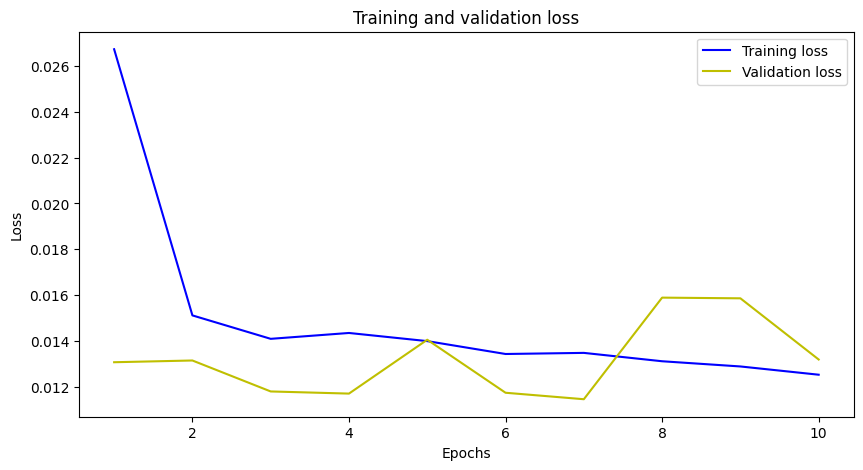

In [41]:
plot_loss(history, 10)

In [42]:
predictions = autoencoder.predict(down_test)

16/16 [==============================] - 83s 5s/step


In [43]:
predictions[0].shape

(144, 200, 3)

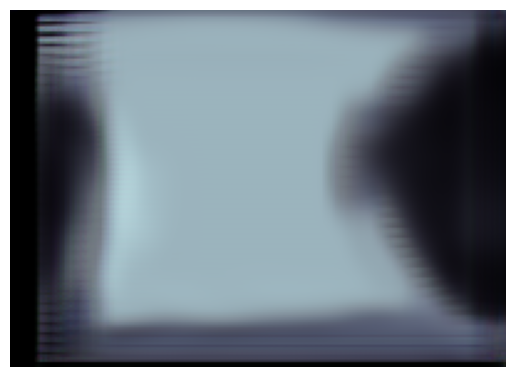

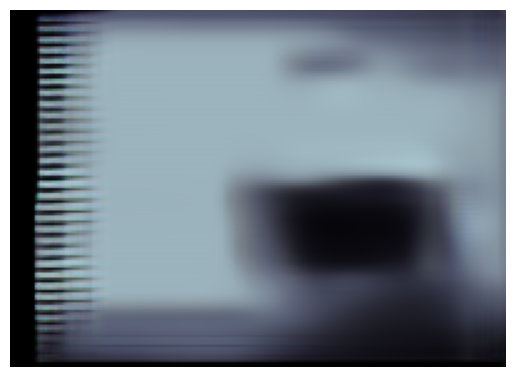

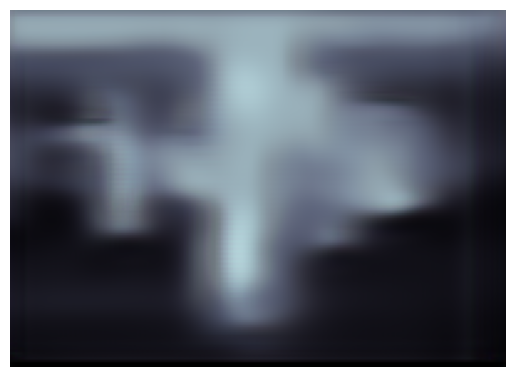

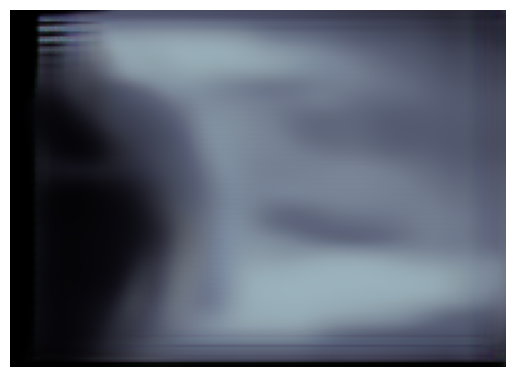

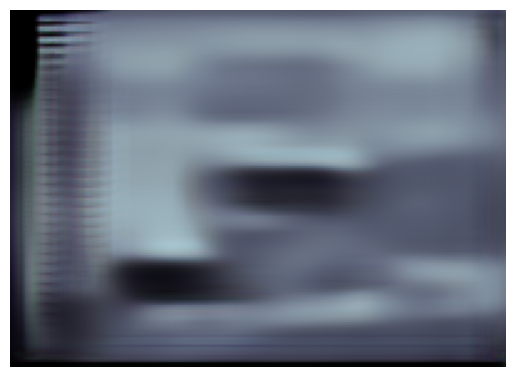

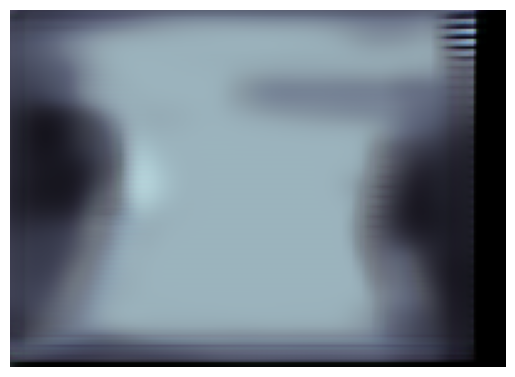

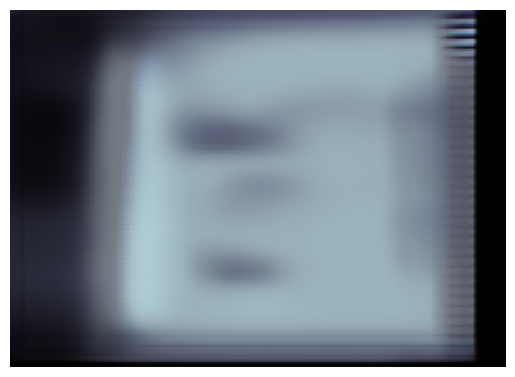

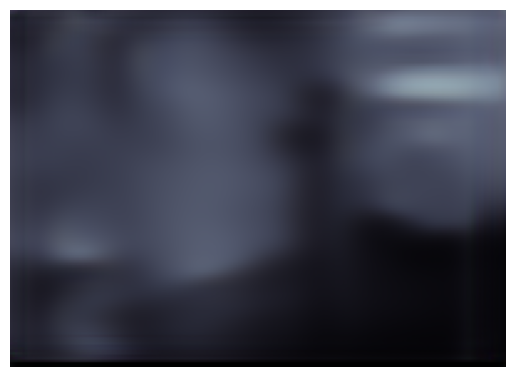

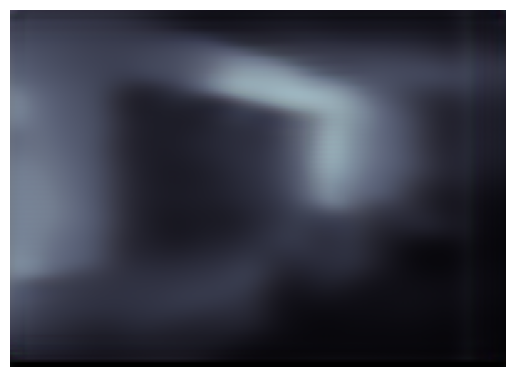

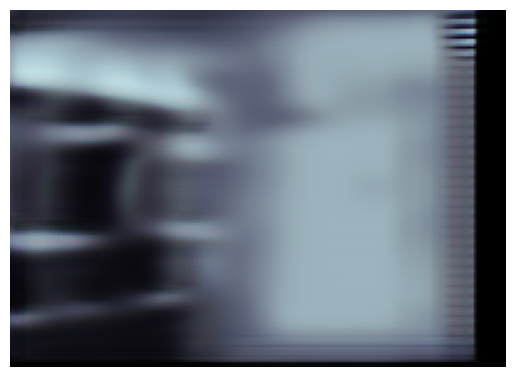

In [44]:
for i in range(10):
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

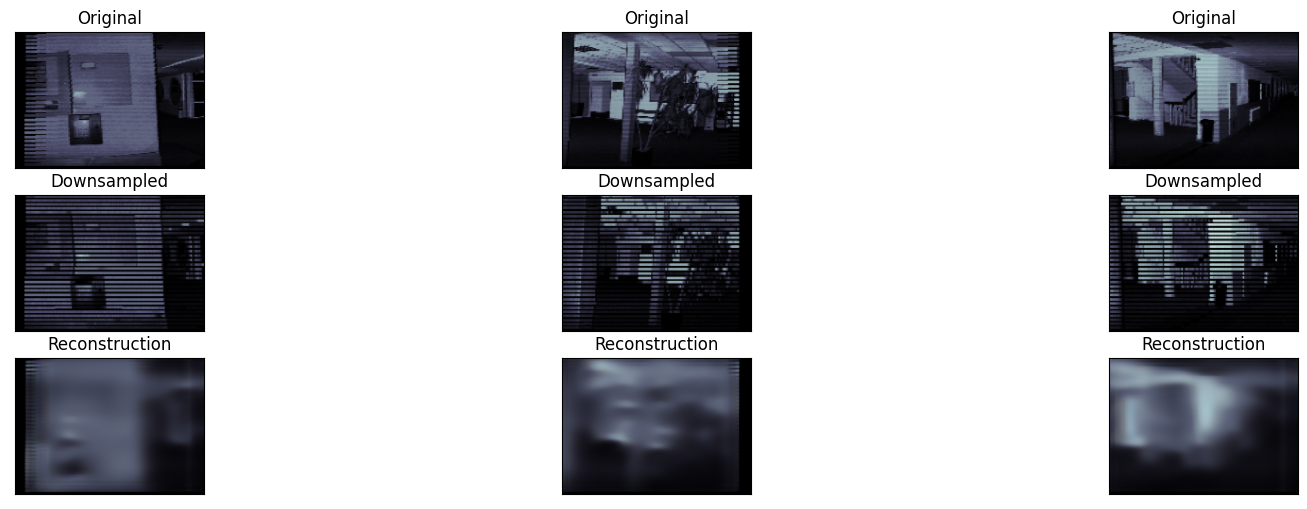

: 

In [45]:
n = 3
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 200, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 200, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 200, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [196]:
np.unique(predictions[0])

array([0.0000000e+00, 1.2575049e-38, 2.6665286e-38, ..., 5.6784779e-01,
       5.9015006e-01, 6.0492355e-01], dtype=float32)

Counts: [11996969  1103632   820280   708210   689995   766717  1131301  2747303
  4065711  3842361  3439669  3156122  2637936  1199366  1190779  1386090
  1543657  1687427  1727994  1692221  1693106  1813854  1745637  1698333
  2130529  2970757  3676289   148922    14878     9429     7134     5894
     3682     2417     1596     1313     1079      904      827      770
      760      761      670      658      684      612      514      342
       91       18]
Bin edges: [0.         0.01923116 0.03846231 0.05769347 0.07692462 0.09615578
 0.11538693 0.13461809 0.15384924 0.1730804  0.19231156 0.21154271
 0.23077387 0.25000504 0.26923618 0.28846735 0.3076985  0.32692966
 0.3461608  0.36539197 0.3846231  0.40385428 0.42308542 0.4423166
 0.46154773 0.4807789  0.5000101  0.5192412  0.53847235 0.55770355
 0.5769347  0.59616584 0.615397   0.6346282  0.6538593  0.67309046
 0.6923216  0.7115528  0.73078394 0.7500151  0.7692462  0.7884774
 0.80770856 0.8269397  0.84617084 0.86540204 0.8846332  

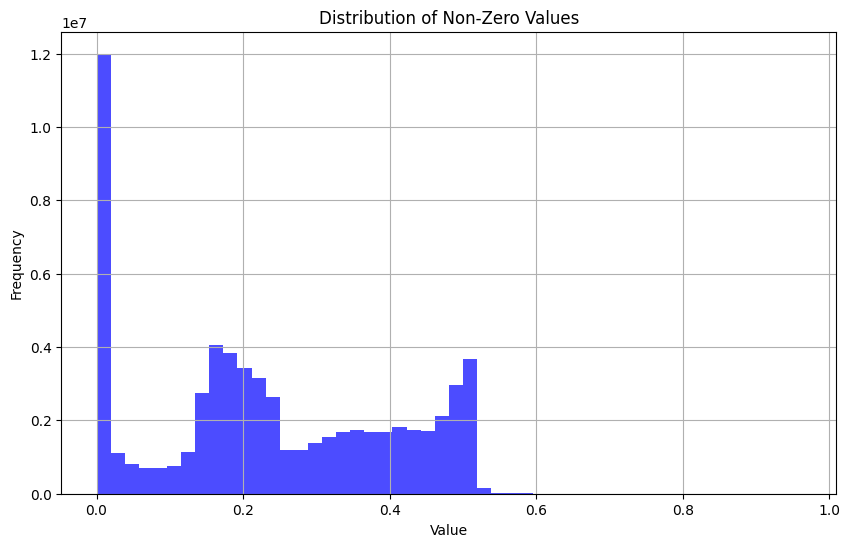

In [197]:
non_zero_data = predictions[predictions != 0].flatten()
data = predictions.flatten()

counts, bin_edges = np.histogram(data, bins=50)

print("Counts:", counts)
print("Bin edges:", bin_edges)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Non-Zero Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Modelo 2

In [33]:
# Encoder
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.3)(encoder)

encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)
# encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)

# Decoder
# decoder = Conv2DTranspose(32, (12, 12), activation='relu', padding='same')(encoder)
# decoder = Conv2DTranspose(512, (3, 3), activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(decoder)
encoder = Dropout(0.2)(encoder)

decoder = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
encoder = Dropout(0.2)(encoder)
# decoder = Dropout(0.3)(decoder)
decoder = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(decoder)

In [34]:
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [35]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 800, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 144, 800, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 144, 800, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 72, 400, 32)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 72, 400, 32)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 400, 64)       18496     
                                                           

In [52]:
history = autoencoder.fit(train_down, train_orig, epochs=EPOCHS, batch_size=16, validation_data=(test_down, test_orig))

Epoch 1/5
50/50 [==============================] - 254s 5s/step - loss: 0.1203 - val_loss: 0.0820
Epoch 2/5
50/50 [==============================] - 229s 5s/step - loss: 0.0653 - val_loss: 0.0569
Epoch 3/5
50/50 [==============================] - 222s 4s/step - loss: 0.0521 - val_loss: 0.0501
Epoch 4/5
50/50 [==============================] - 222s 4s/step - loss: 0.0487 - val_loss: 0.0480
Epoch 5/5
50/50 [==============================] - 220s 4s/step - loss: 0.0454 - val_loss: 0.0463


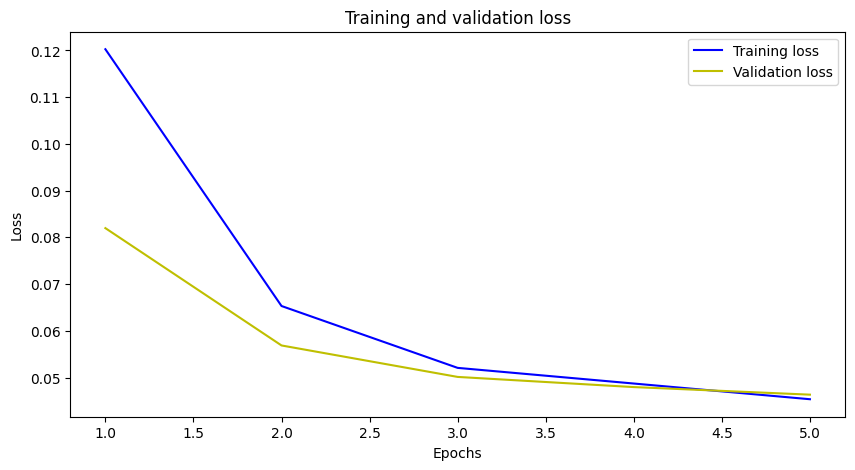

In [53]:
plot_loss(history, EPOCHS)

In [54]:
predictions = autoencoder.predict(down_test)

9/9 [==============================] - 23s 2s/step


In [ ]:
for i in range(10):
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

In [ ]:
n = 3
plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_orig[i].reshape(146, 207, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_down[i].reshape(146, 207, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].reshape(146, 207, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Modelo 3

In [29]:
# Encoder
encoder = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
encoder = Conv2D(32, (5, 5), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Conv2D(64, (5, 5), activation='relu', padding='same')(encoder)
encoder = Conv2D(64, (5, 5), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Conv2D(128, (5, 5), activation='relu', padding='same')(encoder)
encoder = Conv2D(128, (5, 5), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.3)(encoder)

encoder = Conv2D(256, (5, 5), activation='relu', padding='same')(encoder)
encoder = Conv2D(256, (5, 5), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)
# encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)

# Decoder
# decoder = Conv2DTranspose(32, (12, 12), activation='relu', padding='same')(encoder)
# decoder = Conv2DTranspose(512, (3, 3), activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(256, (5, 5), strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(256, (5, 5), activation='relu', padding='same')(decoder)
encoder = Dropout(0.2)(encoder)

decoder = Conv2DTranspose(128, (5, 5), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(128, (5, 5), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
encoder = Dropout(0.2)(encoder)
# decoder = Dropout(0.3)(decoder)
decoder = Conv2DTranspose(64, (5, 5), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(32, (5, 5), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(decoder)

In [30]:
autoencoder1 = Model(inputs=input_layer, outputs=decoder)

In [31]:
autoencoder1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 800, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 144, 800, 32)      2432      
                                                                 
 conv2d_10 (Conv2D)          (None, 144, 800, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 72, 400, 32)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 72, 400, 32)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 400, 64)       51264     
                                                           

In [32]:
history = autoencoder1.fit(train_down, train_orig, epochs=20, batch_size=4, validation_data=(test_down, test_orig))

Epoch 1/20
300/300 [==============================] - 1028s 3s/step - loss: 0.0237 - val_loss: 0.0141
Epoch 2/20
300/300 [==============================] - 1029s 3s/step - loss: 0.0142 - val_loss: 0.0159
Epoch 3/20
300/300 [==============================] - 1014s 3s/step - loss: 0.0130 - val_loss: 0.0123
Epoch 4/20
300/300 [==============================] - 1014s 3s/step - loss: 0.0125 - val_loss: 0.0103
Epoch 5/20
300/300 [==============================] - 1015s 3s/step - loss: 0.0114 - val_loss: 0.0111
Epoch 6/20
300/300 [==============================] - 1013s 3s/step - loss: 0.0104 - val_loss: 0.0094
Epoch 7/20
300/300 [==============================] - 1025s 3s/step - loss: 0.0100 - val_loss: 0.0085
Epoch 8/20
300/300 [==============================] - 1030s 3s/step - loss: 0.0095 - val_loss: 0.0085
Epoch 9/20
300/300 [==============================] - 1016s 3s/step - loss: 0.0086 - val_loss: 0.0077
Epoch 10/20
300/300 [==============================] - 1009s 3s/step - loss: 0.008

In [29]:
# autoencoder1.save('autoencoder1.h5')
# autoencoder1 = tf.keras.models.load_model('autoencoder1.h5')

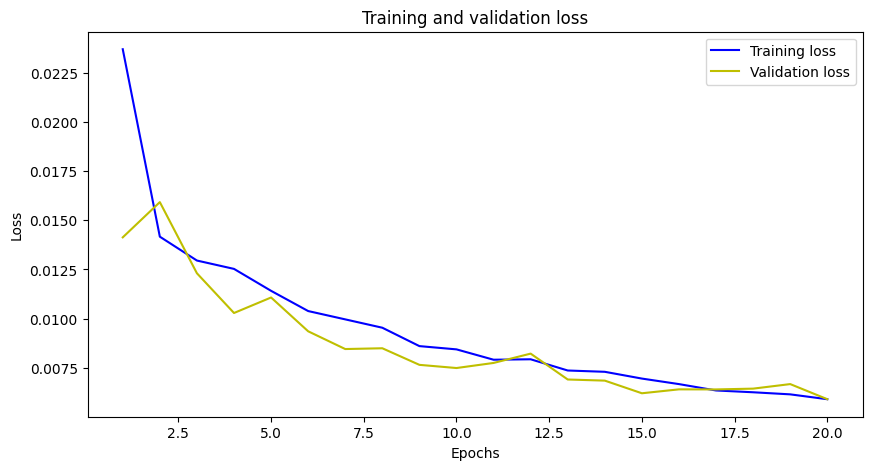

: 

In [34]:
plot_loss(history, 20)

In [ ]:
for i in range(10):
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

In [ ]:
n = 3  
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## U-Net

#### UNet 1

In [ ]:
def unet_model(input_size=input_dim):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(16, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Cuello de botella
    c4 = Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    d = Dropout(0.5)(c4)

    # Decoder
    u6 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(d)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    
    u7 = Conv2DTranspose(32, (7, 7), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    
    u8 = Conv2DTranspose(16, (7, 7), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(16, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    
    # Capa de salida
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


u_net = unet_model()

In [ ]:
u_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 144, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 800, 16  2368        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 72, 400, 16)  0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
history = u_net.fit(train_down, train_orig, epochs=10, batch_size=16, validation_data=(test_down, test_orig))

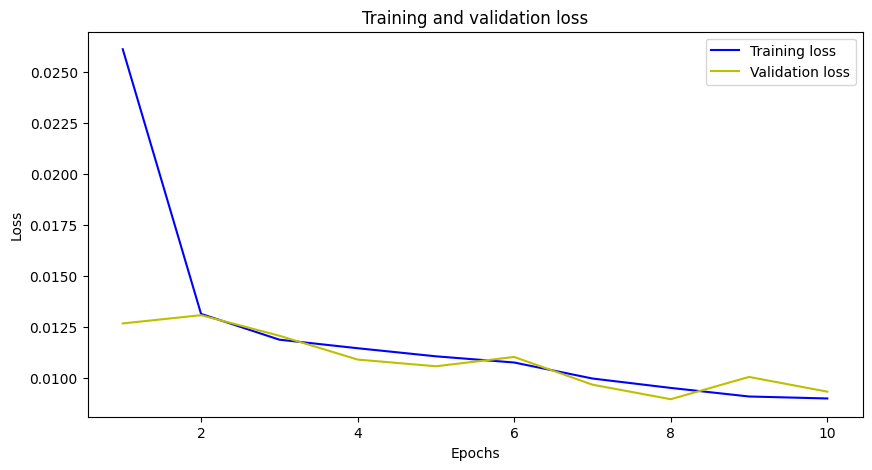

In [ ]:
plot_loss(history, 10)

In [ ]:
u_net.save('u_net_model_simple_etsisi.h5')

In [ ]:
predictions = u_net.predict(down_test)

16/16 [==============================] - 37s 2s/step


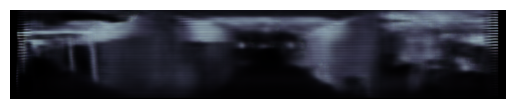

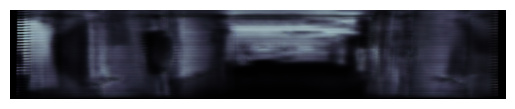

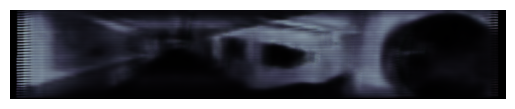

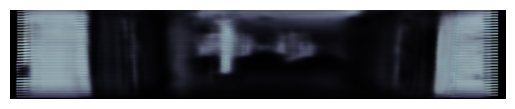

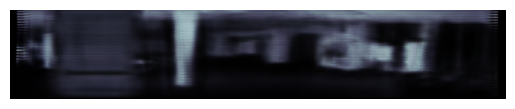

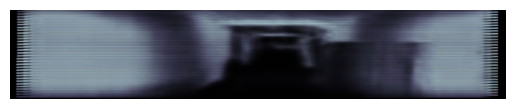

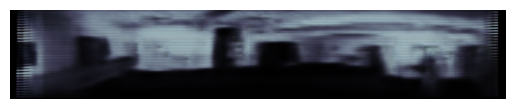

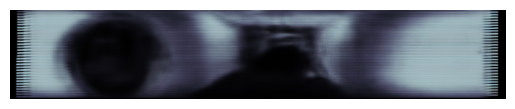

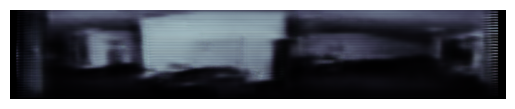

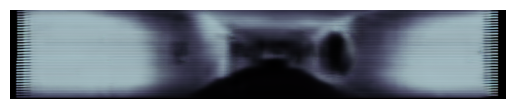

In [ ]:
for i in range(10):
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

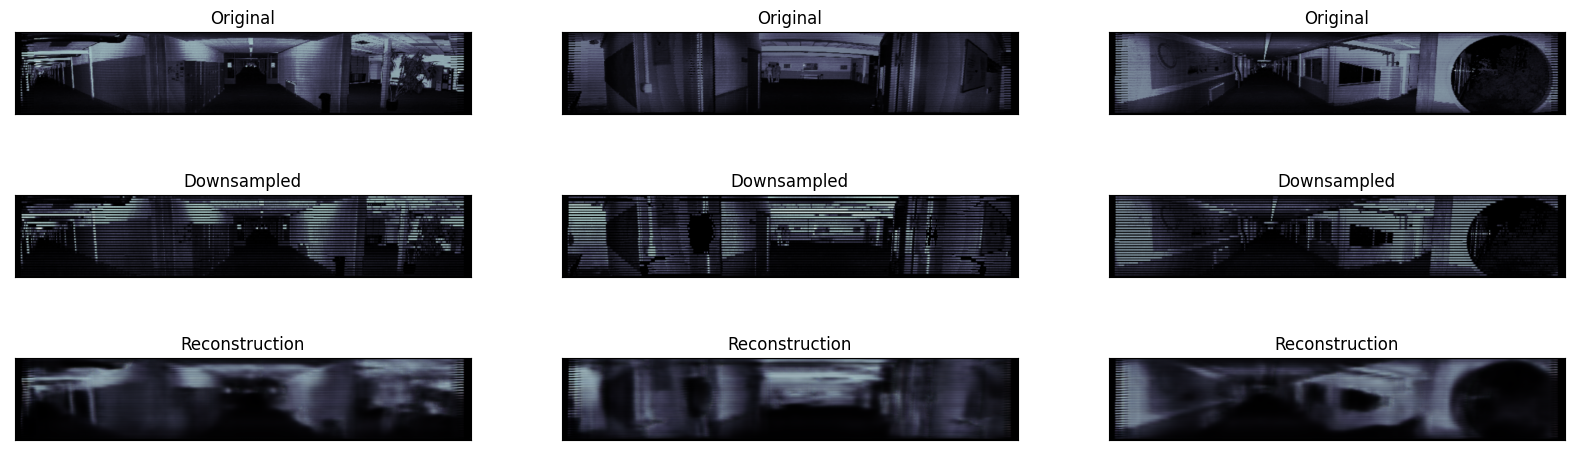

In [ ]:
n = 3
plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[i].reshape(144, 800, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[i].reshape(144, 800, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].reshape(144, 800, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### UNet 2

In [26]:
def unet_model(input_size=input_dim):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Cuello de botella
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    d = Dropout(0.3)(c4)

    # Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    # Capa de salida
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

u_net1 = unet_model()

In [27]:
u_net1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 144, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 800, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 144, 800, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [28]:
history = u_net1.fit(train_down, train_orig, epochs=15, batch_size=4, validation_data=(test_down, test_orig))

Epoch 1/15
300/300 [==============================] - 632s 2s/step - loss: 0.0188 - val_loss: 0.0117
Epoch 2/15
300/300 [==============================] - 634s 2s/step - loss: 0.0124 - val_loss: 0.0121
Epoch 3/15
300/300 [==============================] - 631s 2s/step - loss: 0.0116 - val_loss: 0.0132
Epoch 4/15
300/300 [==============================] - 639s 2s/step - loss: 0.0107 - val_loss: 0.0099
Epoch 5/15
300/300 [==============================] - 635s 2s/step - loss: 0.0100 - val_loss: 0.0094
Epoch 6/15
300/300 [==============================] - 625s 2s/step - loss: 0.0093 - val_loss: 0.0082
Epoch 7/15
300/300 [==============================] - 613s 2s/step - loss: 0.0086 - val_loss: 0.0085
Epoch 8/15
300/300 [==============================] - 630s 2s/step - loss: 0.0083 - val_loss: 0.0077
Epoch 9/15
300/300 [==============================] - 649s 2s/step - loss: 0.0082 - val_loss: 0.0076
Epoch 10/15
300/300 [==============================] - 646s 2s/step - loss: 0.0076 - val_lo

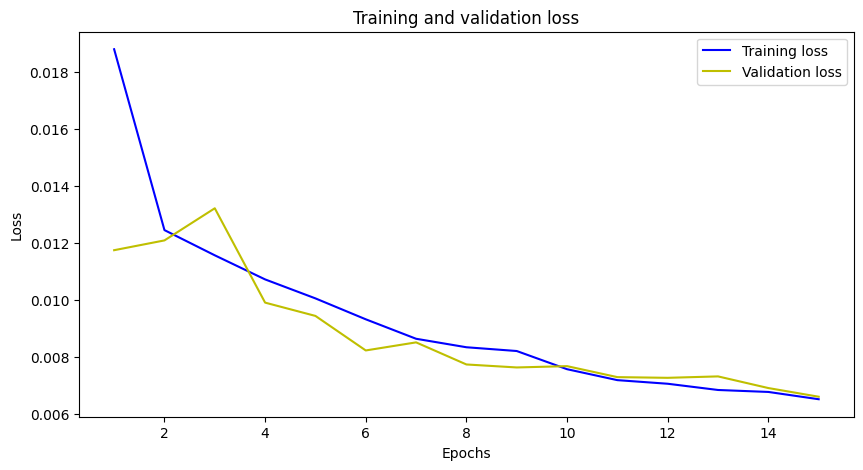

: 

In [29]:
plot_loss(history, 15)

In [ ]:
u_net1.save('u_net_model_etsisi2.h5')

In [30]:
predictions1 = u_net1.predict(down_test)

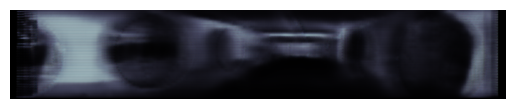

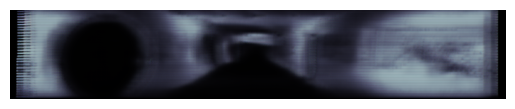

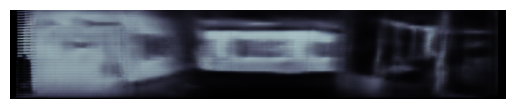

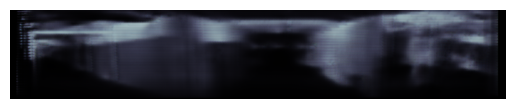

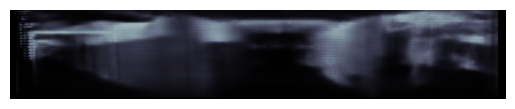

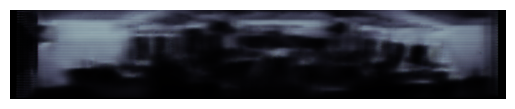

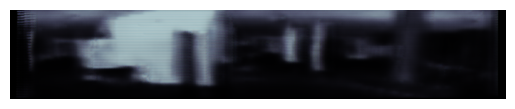

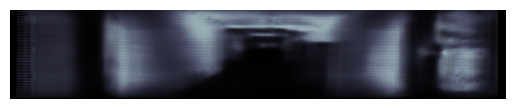

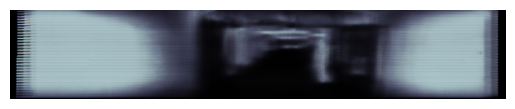

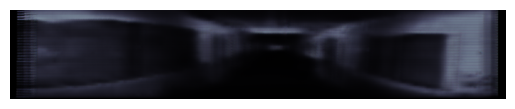

In [ ]:
for i in range(10):
    plt.imshow(predictions1[i])
    plt.axis('off')
    plt.show()

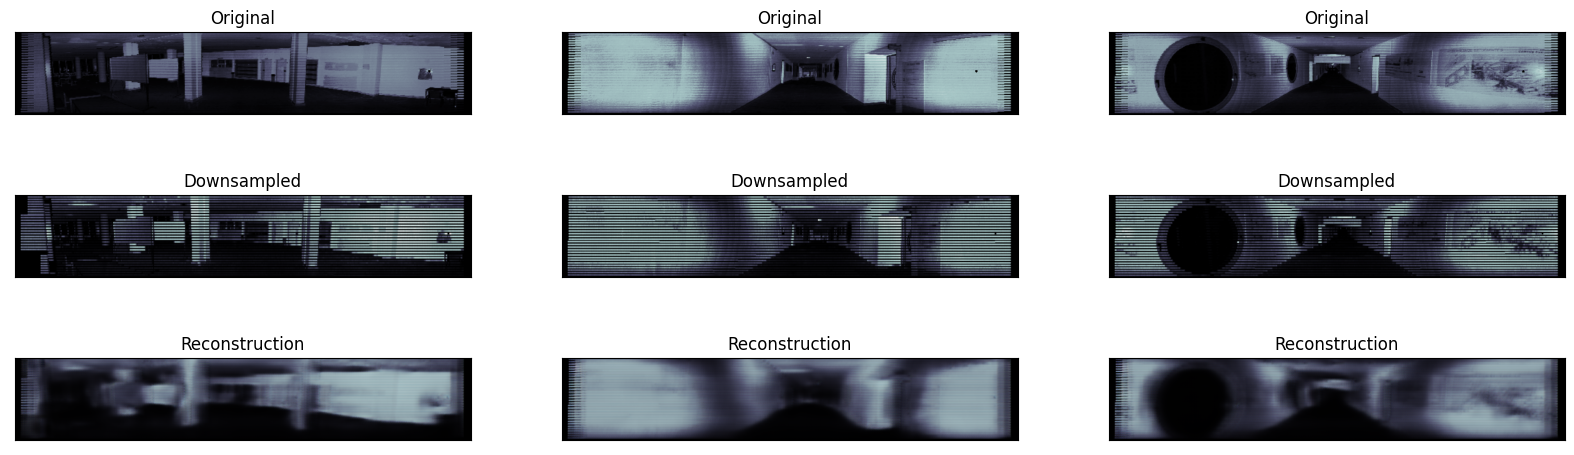

In [ ]:
n = 3  

indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions1[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Unet 3

In [ ]:
def unet_model(input_size=input_dim): 
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    # p1 = AveragePooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    # p2 = AveragePooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    # p3 = AveragePooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    # p4 = AveragePooling2D((2, 2))(c4)

    # Bottleneck
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    d = Dropout(0.3)(c6)

    # Decoder
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d)
    u7 = concatenate([u7, c4])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c3])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8) 
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c2])
    c9 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c1])
    c10 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c10)


    # Capa de salida
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c10)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

u_net = unet_model()

In [ ]:
u_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 144, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 800, 32  2432        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 144, 800, 32  25632       ['conv2d[0][0]']                 
                                )                                                             

In [72]:
history = u_net.fit(train_down, train_orig, epochs=30, batch_size=16, validation_data=(test_down, test_orig))

Epoch 1/30
75/75 [==============================] - 1189s 16s/step - loss: 0.0312 - val_loss: 0.0133
Epoch 2/30
75/75 [==============================] - 1183s 16s/step - loss: 0.0135 - val_loss: 0.0131
Epoch 3/30
75/75 [==============================] - 1182s 16s/step - loss: 0.0127 - val_loss: 0.0123
Epoch 4/30
75/75 [==============================] - 1184s 16s/step - loss: 0.0120 - val_loss: 0.0122
Epoch 5/30
75/75 [==============================] - 1185s 16s/step - loss: 0.0118 - val_loss: 0.0108
Epoch 6/30
75/75 [==============================] - 1183s 16s/step - loss: 0.0112 - val_loss: 0.0117
Epoch 7/30
75/75 [==============================] - 1187s 16s/step - loss: 0.0102 - val_loss: 0.0101
Epoch 8/30
75/75 [==============================] - 1185s 16s/step - loss: 0.0107 - val_loss: 0.0092
Epoch 9/30
75/75 [==============================] - 1205s 16s/step - loss: 0.0096 - val_loss: 0.0095
Epoch 10/30
75/75 [==============================] - 1186s 16s/step - loss: 0.0093 - val_lo

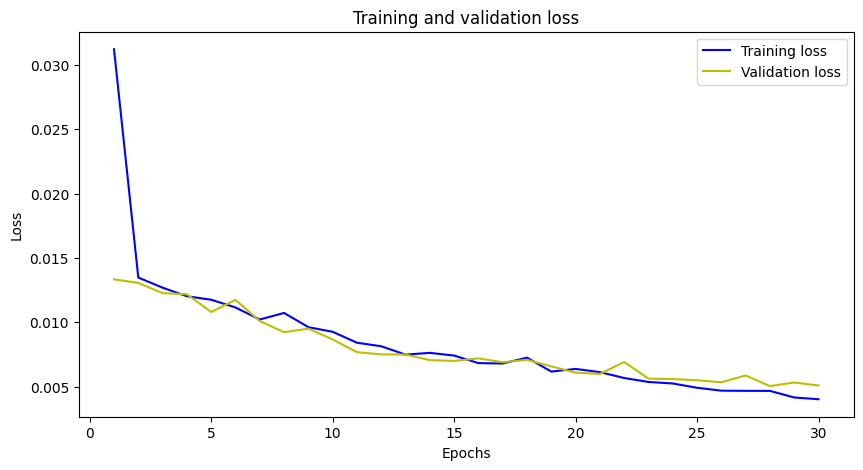

In [74]:
plot_loss(history, 30)

In [75]:
u_net.save('u_net_model_8m_params.h5')

In [76]:
predictions = u_net.predict(down_test)

16/16 [==============================] - 99s 6s/step


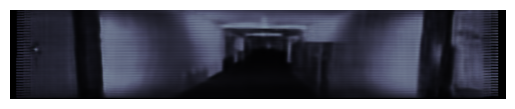

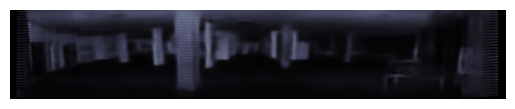

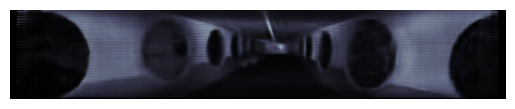

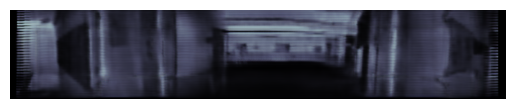

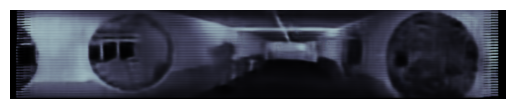

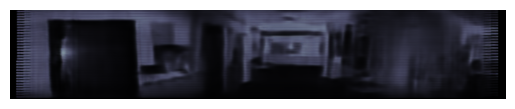

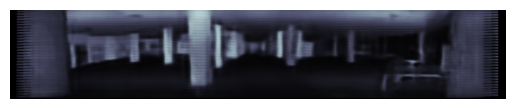

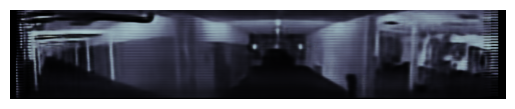

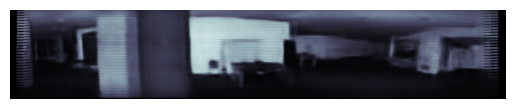

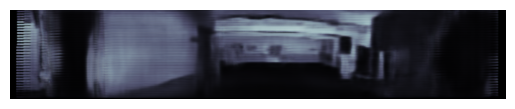

In [77]:
indices = np.random.choice(len(down_test), 10, replace=False)

for i in indices:
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

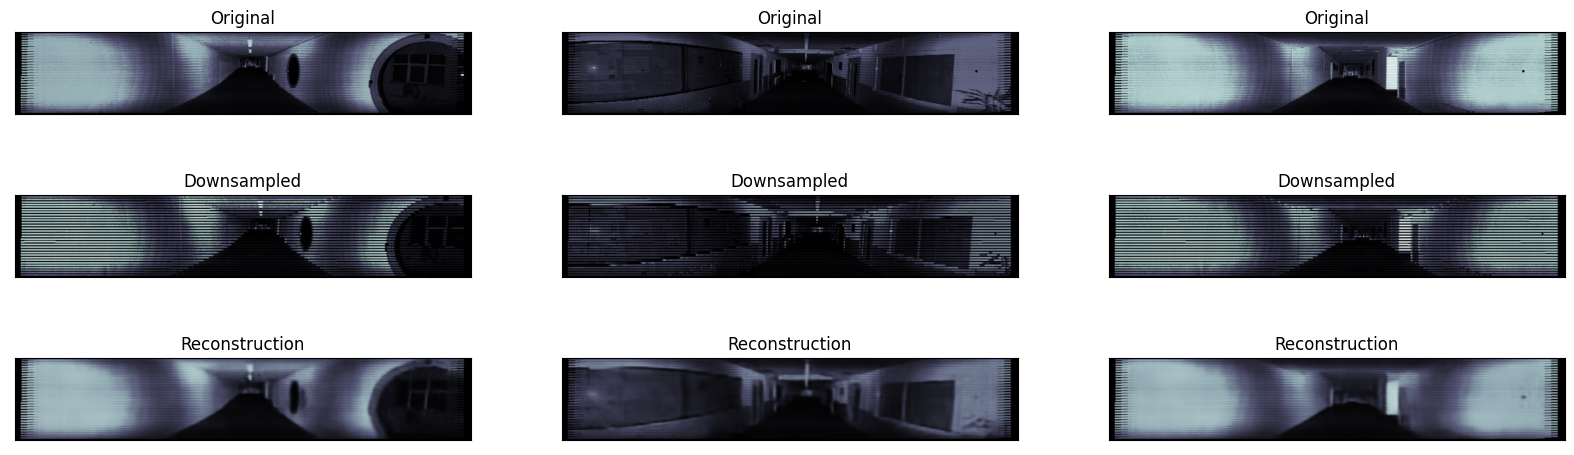

In [82]:
n = 3
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 800, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()